# Network definitions

In [2]:
# Definitions
from tensorflow.keras import layers as L 
import tensorflow as tf
from functools import reduce

import numpy as np

class ResidualConv(tf.keras.Model):
    def __init__(self, filters, kernel_size, use_bn=True, activation=tf.nn.elu, **kwargs):
        super().__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.c1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME', **kwargs)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.c2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME', **kwargs)
        self.activation = activation
    @tf.function
    def call(self, x):
        y = self.activation(self.c1(self.bn1(x)))
        y = self.activation(self.c2(self.bn2(y)))
        #print(x.shape)
        return y + x

def round_even(x):
    if x % 2 == 0:
        return x + 1
    else:
        return x + 2
    
class ConvRegressor(tf.keras.Model):
    def __init__(
        self, filters, kernel_size, 
        conv_type=tf.keras.layers.Conv2D, activation=tf.nn.elu, 
        **kwargs
    ):
        super().__init__()
        self.filters = filters
        self.conv_type = conv_type
        self.convs = []
        for n_filter in filters:
            self.convs.append(
                conv_type(n_filter, round_even(kernel_size), strides=2, padding='SAME', activation=activation, **kwargs)
            )
            self.convs.append(conv_type(n_filter, kernel_size, padding='SAME', activation=activation, **kwargs))
        self.convs.append(tf.keras.layers.Conv2D(n_filter, kernel_size, padding='SAME'))

    @tf.function
    def call(self, x):
        y = x
        for conv in self.convs:
            y = conv(y)
        return y

class ResidualConvRegressor(tf.keras.Model):
    def __init__(
        self, filters, out_ch, kernel_size, n_freq_residual, 
        conv_type=tf.keras.layers.Conv2D, activation=tf.nn.elu, 
        **kwargs
    ):
        super().__init__()
        self.filters = filters
        self.n_freq_residual = n_freq_residual
        self.conv_type = conv_type
        self.convs = []
        for n_filter in filters:
            self.convs.append(
                conv_type(
                    n_filter, round_even(kernel_size), strides=2, 
                    activation=activation, padding='SAME', **kwargs)
            )
            for i in range(n_freq_residual):
                self.convs.append(
                    ResidualConv(n_filter, kernel_size, activation=activation, **kwargs)
                )
        self.convs.append(tf.keras.layers.Conv2D(out_ch, kernel_size, padding='SAME'))
    @tf.function
    def call(self, x):
        y = x
        for conv in self.convs:
            y = conv(y)
        return y
    
class ConvVAE(tf.keras.Model):
    def __init__(
        self, dim_list, latent_dim, out_ch=1, kernel_size=3, 
        crop_bb=None, **kwargs
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.crop_bb = crop_bb
        self.out_ch = out_ch
        self.inference_net = self.create_regressor(
            dim_list, kernel_size, conv_type=tf.keras.layers.Conv2D,
            **kwargs)
        self.dense_inference = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim * 2),
        ])
        self.deconv_start_shape = (4, 4)
        self.deconv_start_dim = 16
        self.dense_z = tf.keras.layers.Dense(self.deconv_start_dim)
        self.generative_net = self.create_regressor(
            dim_list[::-1], kernel_size, conv_type=tf.keras.layers.Conv2DTranspose,
            **kwargs)
        self.final_conv = tf.keras.layers.Conv2D(out_ch, kernel_size, padding='SAME')

    def create_regressor(self, dim_list, kernel_size, **kwargs):
        return ConvRegressor(dim_list, kernel_size=kernel_size, **kwargs)
    @tf.function
    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        d = self.decode(z)
        return self.crop(d)
    
    @tf.function
    def crop(self, x):
        if self.crop_bb is None:
            return x
        else:
            return tf.image.crop_to_bounding_box(x, *self.crop_bb)
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        self.orig_latent = self.inference_net(x)
        self.latent = self.dense_inference(self.orig_latent)
        mean, logvar = tf.split(self.latent, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        z = self.dense_z(z)
        s = int(np.sqrt(self.deconv_start_dim))
        z = tf.reshape(z, (tf.shape(z)[0], s, s, 1))
        logits = self.final_conv(self.generative_net(z))
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits
    
class ResidualConvVAE(ConvVAE):
    def __init__(
        self, dim_list, latent_dim, 
        out_ch=1, n_freq_residual=4,
        kernel_size=3, crop_bb=None, **kwargs
    ):
        self.n_freq_residual = n_freq_residual
        super().__init__(dim_list, latent_dim, out_ch=out_ch, kernel_size=kernel_size, crop_bb=crop_bb, **kwargs)

    def create_regressor(self, dim_list, kernel_size, **kwargs):
        return ResidualConvRegressor(
            dim_list, dim_list[-1], kernel_size=kernel_size,
            n_freq_residual=self.n_freq_residual, **kwargs)

class ResiaudlConvDiscriminator(tf.keras.Model):
    def __init__(
        self, filters, out_dim, kernel_size, n_freq_residual, 
    ):
        super().__init__()
        self.convs = ResidualConvRegressor(
            filters[:-1], filters[-1], kernel_size, n_freq_residual)
        self.dense = tf.keras.layers.Dense(out_dim)

    @tf.function
    def call(self, x):
        return self.dense(self.convs(x))

class DenseRegressor(tf.keras.Model):
    def __init__(self, dims, activation=tf.nn.elu, **kwargs):
        super().__init__()
        self.dense_layers = []
        for dim in dims[:-1]:
            self.layers.append(
                tf.keras.layers.Dense(dim, activation, **kwargs)
            )
        self.dense_layers.append(
            tf.keras.layers.Dense(dim, **kwargs)
        )
    def call(self, x):
        y = x
        for d in self.dense_layers:
            y = d(y)
        return y
        

class ResidualDense(tf.keras.Model):
    def __init__(self, units, use_bn=True, activation=tf.nn.elu, **kwargs):
        super().__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.d1 = tf.keras.layers.Dense(units, **kwargs)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.d2 = tf.keras.layers.Dense(units, **kwargs)
        self.activation = activation
    @tf.function
    def call(self, x):
        y = self.activation(self.d1(self.bn1(x)))
        y = self.activation(self.d2(self.bn2(y)))
        return y + x


class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, n_layers=40, n_dims=None, **kwargs):
        super().__init__()
        if n_dims is None:
            n_dims = output_dim
        self.d0 = tf.keras.layers.Dense(n_dims, activation=tf.nn.elu, **kwargs)
        self.dense_layers = [
            ResidualDense(n_dims, **kwargs) for i in range(n_layers)
        ]
        self. d1 = tf.keras.layers.Dense(output_dim, activation=None)
    @tf.function
    def call(self, x):
        y0 = self.d0(x)
        for layer in self.dense_layers:
            y0 = layer(y0)
        y = self.d1(y0)
        return y
net = ResidualConvVAE([8, 16, 32, 64], 12, n_freq_residual=4, kernel_size=3, out_ch=1, crop_bb=(16, 16, 32, 32))
output = net(tf.random.uniform((4, 64, 64, 1)))
net.summary()
print(output.shape)

Model: "residual_conv_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_conv_regressor (Res multiple                  500928    
_________________________________________________________________
sequential (Sequential)      multiple                  24600     
_________________________________________________________________
dense_1 (Dense)              multiple                  208       
_________________________________________________________________
residual_conv_regressor_1 (R multiple                  465984    
_________________________________________________________________
conv2d_70 (Conv2D)           multiple                  73        
Total params: 991,793
Trainable params: 987,953
Non-trainable params: 3,840
_________________________________________________________________
(4, 32, 32, 1)


# Load dataset

In [3]:
import h5py
with h5py.File('3dshapes.h5', 'r') as f:
    images = f['images'].value
    labels = f['labels'].value

C:\Users\kazbi\anaconda3\lib\site-packages\ipykernel_launcher.py:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kazbi\anaconda3\lib\site-packages\ipykernel_launcher.py:4: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  after removing the cwd from sys.path.


In [4]:
from sklearn.model_selection import train_test_split

BATCH_SIZE = 512

resized_images = tf.image.resize(images, (32, 32)).numpy()
resized_images = resized_images.astype(np.float32) / 255
#resized_images = images.astype(np.float32) / 255
labels = labels.astype(np.float32)

indices = np.arange(len(resized_images))
train_indices, test_indices = train_test_split(indices, test_size=0.2)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (resized_images[train_indices], labels[train_indices]))
test_dataset = tf.data.Dataset.from_tensor_slices(
    (resized_images[test_indices], labels[test_indices]))
train_dataset = train_dataset.shuffle(BATCH_SIZE*10, reshuffle_each_iteration=True).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(BATCH_SIZE*5).batch(BATCH_SIZE)

# Training

In [17]:
# from IPython import display
import IPython 
from collections import defaultdict 
from itertools import product
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import time
import seaborn as sns
from io import BytesIO
import imageio
from IPython.display import Image, display_png, clear_output

#%matplotlib widget
%matplotlib inline
#%matplotlib notebook
epochs = 100
latent_dim = 10
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
model = ResidualConvVAE(
    [8, 16, 32], latent_dim, 
    out_ch=3,  kernel_size=3, 
    n_freq_residual=5,
    #initializer=tf.initializers.glorot_normal,
)
optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.99)
#disc = ResidualRegressor(2, n_layers=5, n_dims=1000)
disc = DenseRegressor([1000, 1000, 1000, 1000, 1000, 1000, 2])
disc_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.99)

state_training_discriminator_epoch = 30
training_params = {}

def gaussian_kl_divergence(mean, ln_var, raxis=1):
    var = tf.exp(ln_var)
    mean_square = mean * mean
    return tf.reduce_sum((mean_square + var - ln_var - 1) * 0.5, axis=raxis)

#@tf.function
def compute_loss(model, x):
    # Compute VAE loss
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    reconst_x = model.decode(z)

    absolute_error = (reconst_x - x) ** 2
    loss_reconst = tf.reduce_sum(absolute_error, axis=(1,2,3))
    loss_kld = gaussian_kl_divergence(mean, logvar)
    
    # Discriminator loss
    ## Make permute indices

    z_shape = z.shape
#     indices = list(range(z_shape[1])) * z_shape[0]
#     swap_index_pair = np.random.randint(0, latent_dim, size=(z_shape[0], 2), dtype=np.int32)
    indices = list(range(z_shape[1]))
    swap_index_pair = np.random.choice(indices, size=2, replace=False)
    tmp = indices[swap_index_pair[0]]
    indices[swap_index_pair[0]] = indices[swap_index_pair[1]]
    indices[swap_index_pair[1]] = tmp
#     for i in range(len(swap_index_pair)):
#         tmp = indices[swap_index_pair[i, 0]]
#         indices[swap_index_pair[i, 1]] = indices[swap_index_pair[i, 0]]
#         indices[swap_index_pair[i, 1]] = tmp
    nd_indices = [
        [i, j] for i, j in product(range(z_shape[0]), indices)
    ]
    
    z_shuffled = tf.reshape(tf.gather_nd(z, tf.convert_to_tensor(nd_indices)), z_shape)

    ## Compute loss
    logits_orig_z = disc(z)
    logits_shuffle_z = disc(z_shuffled)
    
    loss_tc = tf.gather(logits_orig_z, 0, axis=1) - tf.gather(logits_orig_z, 1, axis=1)
    loss_disc = (0.5 * tf.keras.activations.softplus(-tf.gather(logits_orig_z, 0, axis=1))\
        + 0.5 * tf.keras.activations.softplus(-tf.gather(logits_shuffle_z, 0, axis=1)))
    
    ## Image quality discriminator
    #logits_real_image = img_disc(tf.concat([x, x], axis=3))
    #logits_fake_image = img_disc(tf.concat([x, reconst_x], axis=3))
    
    #loss_quality = tf.reduce_mean(tf.gather(logits_real_image, 0, axis=1)\
    #                         - tf.gather(logits_real_image, 1, axis=1))
    #loss_image_disc = 0.5 * tf.reduce_mean(tf.keras.activations.softplus(-tf.gather(logits_real_image, 0, axis=1)))\
    #    + 0.5 * tf.reduce_mean(tf.keras.activations.softplus(tf.gather(logits_fake_image, 1, axis=1)))

    return {
        'loss': {
            'Reconstruct': tf.reduce_mean(loss_reconst),
            'KL-d': tf.reduce_mean(loss_kld) * 1e-1,
            'TotalCorrelation': tf.reduce_mean(loss_tc) * 1e-2,
            #'Quality': loss_quality,
        },
        'loss_disc': {
            'Permutation': tf.reduce_mean(loss_disc)
        },
        #'loss_img_disc': {
        #    'Loss':  tf.reduce_mean(loss_image_disc)
        #},
        'raw': {
            'AE': absolute_error, 
            'Original': x,
            'Reconstruct': reconst_x,
            'ProbOriginal': logits_orig_z,
            'ProbPermutation': logits_shuffle_z,
        }
    }

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape, \
            tf.GradientTape() as disc_tape:
            #tf.GradientTape() as img_disc_tape:
        losses = compute_loss(model, x)
        disc_loss = sum(losses['loss_disc'].values())

        loss = sum(losses['loss'].values())
        #img_disc_loss = sum(losses['loss_img_disc'].values())
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients, disc.trainable_variables))
    
    return losses

#fig, axes = plt.subplots(3, 1, figsize=(5, 8))
fig = plt.figure(figsize=(7, 15))
grid_shape = (6, 3)
loss_ax = plt.subplot2grid(shape=grid_shape, loc=(0, 0), colspan=grid_shape[1], fig=fig)
elbo_ax = plt.subplot2grid(shape=grid_shape, loc=(1, 0), colspan=grid_shape[1], fig=fig)
data_ax = np.zeros((4,3), dtype=np.object)
for i in range(4):
    for j in range(3):
        data_ax[i, j] = plt.subplot2grid(shape=grid_shape, loc=(2 + i, j), fig=fig)

        
plt.ion()
fig.show()
fig.canvas.draw()

loss_history = defaultdict(list)
elbo_history = []
with tf.device('/GPU:0'):
    for epoch in trange(1, epochs + 1):
        training_params['epoch'] = epoch
        
        start_time = time.time()
        for train_x, _ in tqdm(train_dataset):
            data = compute_apply_gradients(model, train_x, optimizer)
            for name, loss in data['loss'].items():
                loss_history[f'vae/{name}'].append(loss.numpy())
            for name, loss in data['loss_disc'].items():
                loss_history[f'Discriminator/{name}'].append(loss.numpy())
#             for name, loss in data['loss_img_disc'].items():
#                 loss_history[f'ImageDiscriminator/{name}'].append(loss.numpy())
            
        end_time = time.time()

        if epoch % 5 == 0:
            loss = tf.keras.metrics.Mean()
            raw = None
            for test_x, _ in tqdm(test_dataset):
                losses = compute_loss(model, test_x)
                if raw is None:
                    raw = losses['raw']
                loss(sum(losses['loss'].values()))
            elbo = -loss.result()
            elbo_history.append(elbo)
            
            loss_ax.clear()
            for name, loss in loss_history.items():
                loss_ax.plot(loss, label=name, alpha=0.5)
            loss_ax.set_xlabel('epoch')
            loss_ax.set_ylabel('Loss')
            loss_ax.set_yscale('log')
            loss_ax.legend(bbox_to_anchor=(0, 1.6), loc='upper left', borderaxespad=0)

            elbo_ax.clear()
            elbo_ax.plot(elbo_history)

            original = np.squeeze(raw['Original'].numpy())
            reconstruct = np.squeeze(raw['Reconstruct'].numpy())
            absolute_error = np.squeeze(raw['AE'].numpy())
            if np.any(np.isnan(absolute_error)):
                tqdm.write('The output is nan.')
            for i in range(4):
                ax = data_ax[i, 0]
                ax.clear()
                ax.imshow(original[i], vmin=0.0, vmax=1.0)
                ax.axis('off')
                
                ax = data_ax[i, 1]
                ax.clear()
                ax.imshow(reconstruct[i], vmin=0.0, vmax=1.0)
                ax.axis('off')
                
                ax = data_ax[i, 2]
                ax.clear()
                ax.imshow(absolute_error[i], vmin=0.0, vmax=1.0)
                ax.axis('off')
            
            io = BytesIO()
            fig.savefig(io, format='png')

            clear_output(wait=True)
            display_png(Image(io.getvalue()))


SyntaxError: invalid character in identifier (<ipython-input-17-80b472b070ff>, line 163)

In [16]:
loss_history['vae/TotalCorrelation'][-1]

-1.1982028

In [65]:
fig.savefig('Training.png')
model.save_weights('VAE.FactorVAE.model')
disc.save_weights('Discriminator.FactorVAE.model')

C:\Users\kazbi\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


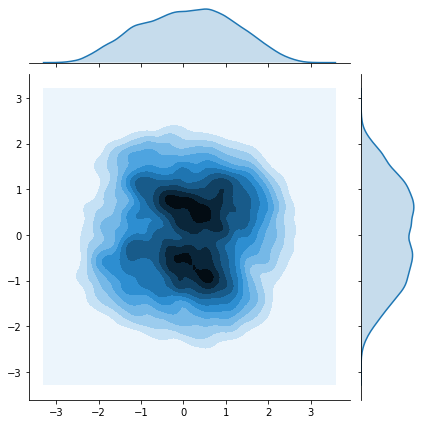

In [10]:
%matplotlib inline
import seaborn as sns
xs = []
ys = []
for x, _ in tqdm(test_dataset):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar).numpy()
    xs.extend(z[:, 0])
    ys.extend(z[:, 1])
    
grid = sns.jointplot(x=xs, y=ys, kind='kde')
grid.fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

C:\Users\kazbi\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


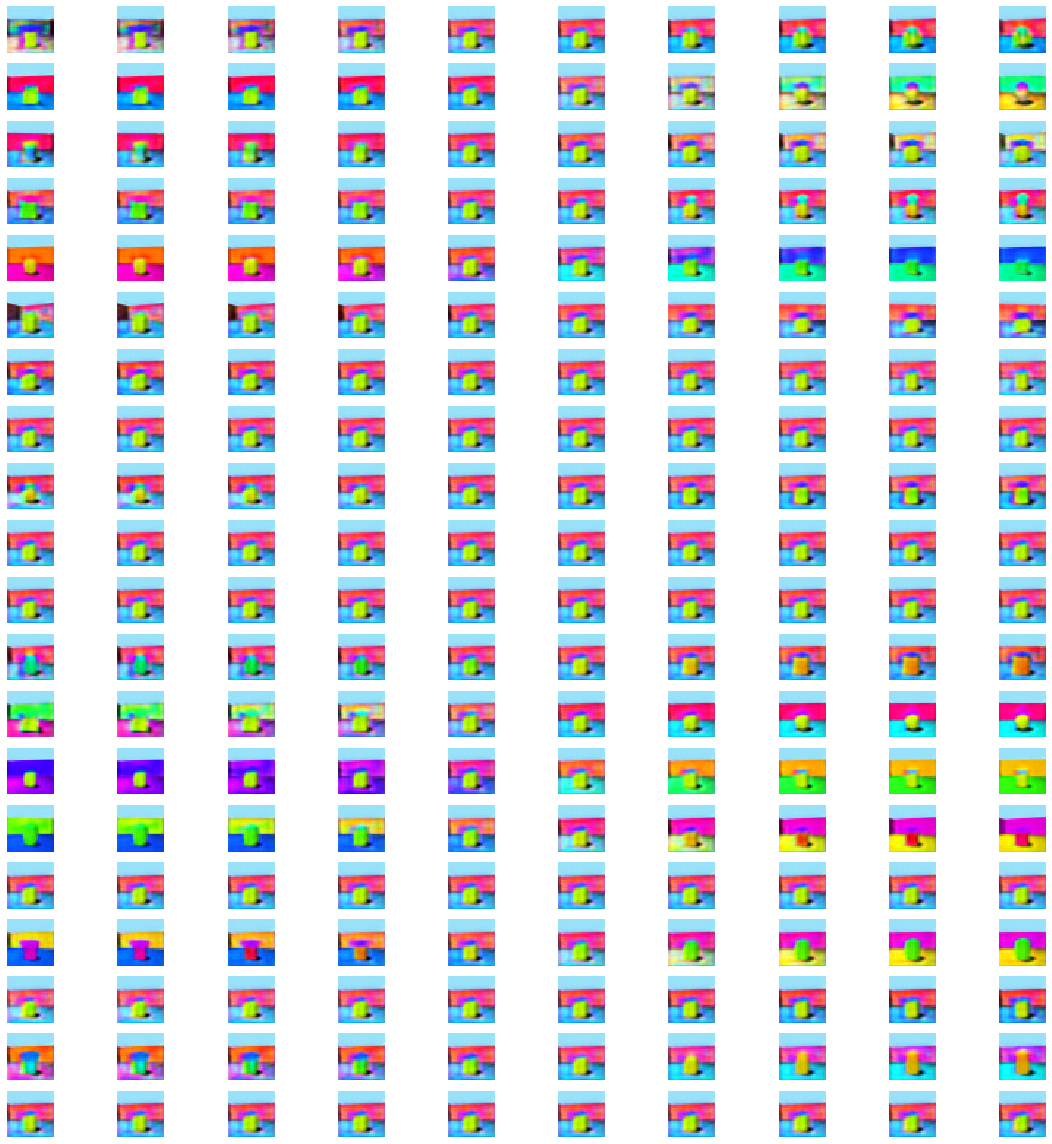

In [14]:
# Latent traversal about each axis

traversal_samples = 10
fig, axes = plt.subplots(latent_dim, traversal_samples, figsize=(16 * traversal_samples / 10, 16))

for latent_index in trange(latent_dim):
    images = []
    latent = np.zeros((traversal_samples, latent_dim), dtype=np.float32)
    latent[:, latent_index] = np.linspace(-2.0, 2.0, traversal_samples)
    images = model.decode(latent).numpy()
    for img, ax in zip(images, axes[latent_index]):
        ax.imshow(img)
        ax.axis('off')
fig.tight_layout()
fig.show()
fig.savefig('LatentTraversal.png')